In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
import xarray as xr 
import cartopy
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# LOAD EOFS
eof_path = '/Users/jakesteinberg/Documents/CPT/vertical_structure/CM_comparisons/prep_for_modes_cmN_2deg_UV.nc'
data = xr.open_dataset(eof_path)
lon_in = data.lon.data
lat_in = data.lat.data

In [3]:
# LOAD MODES 
mode_path = '/Users/jakesteinberg/Documents/CPT/vertical_structure/CM_comparisons/modes_cmN_2deg_globe.nc'
data_modes = xr.open_dataset(mode_path)

In [4]:
data

<xarray.Dataset>
Dimensions:  (lat: 78, lon: 180, z: 50)
Coordinates:
  * z        (z) float64 5.034 15.1 25.22 ... 4.975e+03 5.185e+03 5.395e+03
  * lat      (lat) int64 -78 -76 -74 -72 -70 -68 -66 ... 64 66 68 70 72 74 76
  * lon      (lon) int64 0 2 4 6 8 10 12 14 ... 344 346 348 350 352 354 356 358
Data variables:
    N2       (z, lat, lon) float64 ...
    EOFu     (z, lat, lon) float64 ...
    EOFv     (z, lat, lon) float64 ...
    alpha    (lat, lon) float64 ...
    gamma    (lat, lon) float64 ...

In [5]:
# EOFs and modes are on same z grid 
z = -1*data_modes.z.data
select_mode_all = np.nan*np.ones((len(data_modes.lat),len(data_modes.lon), len(z)))
select_mode_i = np.nan*np.ones((len(data_modes.lat),len(data_modes.lon)))
select_phase = np.nan*np.ones((len(data_modes.lat),len(data_modes.lon)))
for i in tqdm(range(len(data_modes.lat))): # these are indices of the total lat/lon list (match EOF indices)
    for j in range(len(data_modes.lon)):
        # skip if nan 
        if np.isnan(data_modes.fbmi[i,j]):
            continue                
            
        # -- relevant EOF
        this_EOF = np.flip(data.EOFv[:,data_modes.lat[i].data,data_modes.lon[j].data].data)
        # skip if nan 
        if np.sum(np.isnan(this_EOF)) > 25:
            continue          
    
        these_modes = data_modes.modes[i,j,0,:,:,1].data # 1st, baroclinic modes (sb + fb)
        this_fb_m0 = data_modes.modes[i,j,0,np.int(data_modes.fbmi[i,j]),:,0].data # 0th, barotropic mode 
        these_phases = data_modes.phase[i,j,0,:,1] # phase speeds of modes 
        # -- non-nan z coords
        # good = np.where(~np.isnan(these_modes[np.int(data_modes.fbmi[i,j]),:]))[0]
        good_m = np.where(~np.isnan(these_modes[np.int(data_modes.fbmi[i,j]),:]))[0]          # align in the vertical 
        good_e = np.where(~np.isnan(this_EOF))[0]
        good = np.intersect1d(good_m,good_e)
        
        # when finding min, scale by dz 
        dz = z[0:-1] - z[1:]
        dz = np.concatenate((np.array([dz[0]])[None,:],dz[None,:]),axis=1)
        dz = dz[0,good]
        
        # -- normalize to vertically integrate to 1 (in z, these profiles are shortened by good mask)
        EOF_norm = this_EOF[good] / np.sqrt(np.trapz((this_EOF[good]*this_EOF[good]), (-1*z[good])) / (1*z[good][0]))
        if np.nanmean(EOF_norm[-2:]) < 0:
            EOF_norm = -1*EOF_norm
        fbm0_mode_norm = this_fb_m0[good] / np.sqrt(np.trapz((this_fb_m0[good]*this_fb_m0[good]), (-1*z[good])) / (1*z[good][0]))
        mode_norm = np.nan*np.ones((np.shape(these_modes)[0],len(good)))
        for k in range(np.shape(these_modes)[0]):
            mode_norm[k,:] = these_modes[k,good] / np.sqrt(np.trapz((these_modes[k,good]*these_modes[k,good]), (-1*z[good])) / (1*z[good][0]))
        # -- combine modes to compare to EOF
        mode_test = np.concatenate((fbm0_mode_norm[None,:],mode_norm),axis=0)
        Em_diff = np.nansum(((np.tile(EOF_norm[None,:],(np.shape(mode_test)[0],1)) - mode_test)*np.tile(dz,(np.shape(mode_test)[0],1)))**2,axis=1)
        select_m_i = np.where(Em_diff == np.nanmin(Em_diff))[0][0]
        mode_list = np.concatenate((this_fb_m0[None,:],these_modes),axis=0)
        select_mode_all[i,j,good] = mode_test[select_m_i,:] # mode_list[select_m_i,:]
        select_mode_i[i,j] = select_m_i
        if select_m_i == np.int(data_modes.fbmi[i,j]+1):
            select_mode_i[i,j] = 10
        if select_m_i == 0:
            select_phase[i,j] = np.nan
        else:
            select_phase[i,j] = these_phases[select_m_i - 1]
            if select_phase[i,j] > 10:
                select_phase[i,j] = np.nan

100%|██████████| 69/69 [01:05<00:00,  1.05it/s]


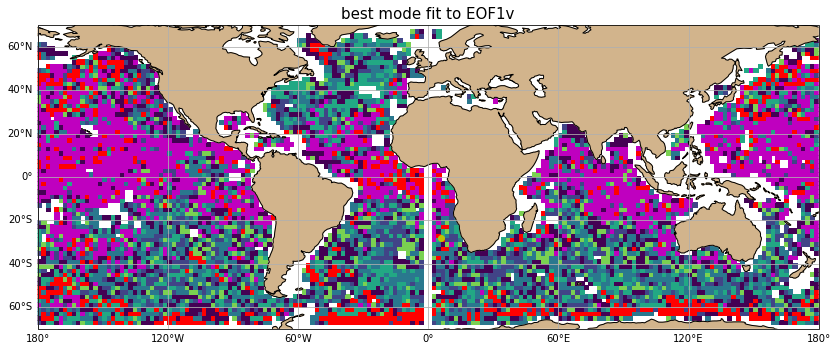

In [6]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cmap = plt.get_cmap('viridis'); cmap.set_under('r'); cmap.set_over('m')
ax.pcolor(lon_in[data_modes.lon.data],lat_in[data_modes.lat.data],select_mode_i,cmap=cmap,vmin=1,vmax=6)
ax.scatter(data_modes.longitude.data[2],data_modes.latitude.data[20],color='y',transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('best mode fit to EOF1v',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# ax.set_xlim([-130,70]); ax.set_ylim([-80,30]); 
# ax.set_xlim([-100,10]); 
ax.set_ylim([-70,70]); 
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_07_19/mode_select_v.jpg', dpi=300)

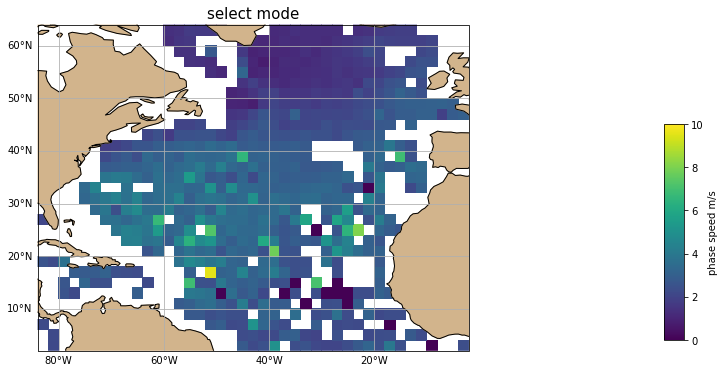

In [9]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cmap = plt.get_cmap('viridis'); cmap.set_under('r'); cmap.set_over('m')
cc = ax.pcolor(lon_in[data_modes.lon.data],lat_in[data_modes.lat.data],select_phase,cmap=cmap,vmin=0,vmax=10)
ax.scatter(data_modes.longitude.data[2],data_modes.latitude.data[20],color='y',transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('select mode',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# ax.set_xlim([-180,180]); ax.set_ylim([-80,80]); 
# ax.set_xlim([-130,70]); ax.set_ylim([-80,30]); 
cbpos = [0.92, 0.15, 0.02, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', label='phase speed m/s')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/mode_select.jpg', dpi=300)

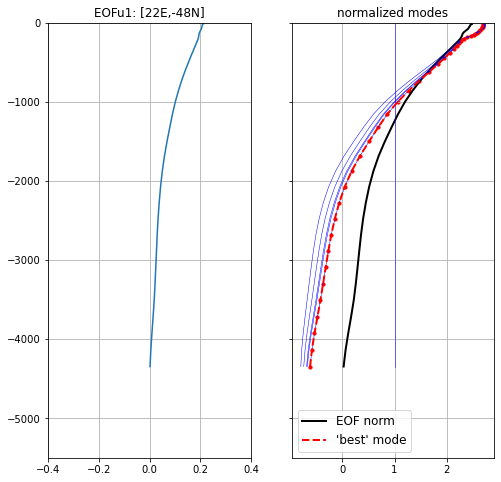

In [7]:
lati = 10
loni = 10
Ki = 0
mi = 1

these_modes = data_modes.modes[lati,loni,0,:,:,1].data                                        # 1st, baroclinic modes (sb + fb)
this_EOF = np.flip(data.EOFu[:,data_modes.lat[lati].data,data_modes.lon[loni].data].data)     # EOF at same loc 
this_fb_m0 = data_modes.modes[lati,loni,0,np.int(data_modes.fbmi[lati,loni]),:,0].data        # 0th, barotropic mode

good_m = np.where(~np.isnan(these_modes[np.int(data_modes.fbmi[lati,loni]),:]))[0]            # align in the vertical 
good_e = np.where(~np.isnan(this_EOF))[0]
good = np.intersect1d(good_m,good_e)
norm_EOF = this_EOF[good] / np.sqrt(np.trapz((this_EOF[good]*this_EOF[good]), (-1*z[good])) / (1*z[good][0])) # normalize 
if np.nanmean(norm_EOF[-2:]) < 0:  # flip sign if needed 
    norm_EOF = norm_EOF*-1

# -- mode selected to best match EOF (test of cell above )
this_mode_check = select_mode_all[lati,loni,:]
# norm_mode_check = this_mode_check[good] / np.sqrt(np.trapz((this_mode_check[good]*this_mode_check[good]), (-1*z[good])) / (1*z[good][0])) # normalize 
# -- compare against all other modes (at this loc)
other_norm_modes = np.nan*np.ones((np.shape(these_modes)[0],len(good)))
for k in range(np.shape(these_modes)[0]):
    other_norm_modes[k,:] = these_modes[k,good] / np.sqrt(np.trapz((these_modes[k,good]*these_modes[k,good]), (-1*z[good])) / (1*z[good][0]))
fbm0_mode_norm = this_fb_m0[good] / np.sqrt(np.trapz((this_fb_m0[good]*this_fb_m0[good]), (-1*z[good])) / (1*z[good][0]))

# combine modes to compare to EOF
mode_test = np.concatenate((fbm0_mode_norm[None,:],other_norm_modes),axis=0)
dz = z[0:-1] - z[1:]
dz = np.concatenate((np.array([dz[0]])[None,:],dz[None,:]),axis=1)
dz = dz[0,good]
Em_diff = np.nansum(((np.tile(norm_EOF[None,:],(np.shape(mode_test)[0],1)) - mode_test)*np.tile(dz,(np.shape(mode_test)[0],1)))**2,axis=1)
select_m_ii = np.where(Em_diff == np.nanmin(Em_diff))[0][0]
mode_list = np.concatenate((this_fb_m0[None,:],these_modes),axis=0)
select_mode = mode_list[select_m_i,:]
select_mode_ii = select_m_ii

# PLOT 
f, (ax0,ax) = plt.subplots(1,2,figsize=(8,8))
# initial EOF 
ax0.plot(this_EOF,-1*z)
ax0.set_title('EOFu1: [' + str(data_modes.longitude[loni].data) + 'E,' + str(data_modes.latitude[lati].data) + 'N]')
ax0.set_ylim([-5500,0])
ax0.set_xlim([-.4,.4])
ax0.grid()
# normalized modes + EOF 
ax.plot(norm_EOF,-1*z[good],color='k',linewidth=2,label='EOF norm')
# ax.plot(norm_mode_check,-1*z[good],color='g',linewidth=5,linestyle='--')
# ax.plot(fbm0_mode_norm,-1*z[good],color='b',linewidth=0.5)
for i in range(np.shape(mode_test)[0]):
    ax.plot(mode_test[i,:],-1*z[good],color='b',linewidth=0.5)
ax.plot(mode_test[select_mode_ii,:],-1*z[good],color='r',linewidth=2, label="'best' mode", linestyle='--')
ax.scatter(mode_test[select_mode_ii,:],-1*z[good],color='r',s=10)
ax.set_ylim([-5500,0])
# ax.set_xlim([-.002,0.002])
ax.set_yticklabels([''])
ax.set_title('normalized modes')
ax.legend(fontsize=12)
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_07_01/mode_select_profile.jpg', dpi=300)

In [57]:
np.concatenate((np.array([dz[0]])[None,:],dz[None,:]),axis=1)

array([[5395.02294922,  209.91210938,  209.90136719,  209.84082031,
         209.80273438,  209.70214844,  209.61230469,  209.4387207 ,
         209.24560547,  208.93408203,  208.54711914,  207.96875   ,
         207.21923828,  206.14086914,  204.71411133,  202.71972656,
         200.07128906,  196.46374512,  191.73095703,  185.49536133,
         177.56518555,  167.62060547,  155.66082764,  141.72174072,
         126.30145264,  109.98895264,   93.72070312,   78.256073  ,
          64.36129761,   52.3572998 ,   42.45690918,   34.48269653,
          28.29089355,   23.51429749,   19.95050049,   17.25869751,
          15.30711365,   13.83808899,   12.80190277,   12.01049805,
          11.47290039,   11.0463028 ,   10.77410126,   10.54109955,
          10.40850067,   10.27689743,   10.21789932,   10.13910103,
          10.11870098,   10.06710005]])

In [56]:
np.shape(dz[None,:])

(1, 49)

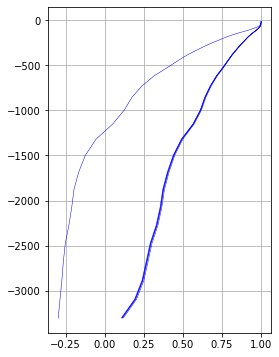

In [12]:
f, ax = plt.subplots(1,1,figsize=(4,6))
for i in range(np.shape(these_modes)[0]):
    # ax.plot(other_norm_modes[i,:],-1*z[good],color='b',linewidth=0.5)
    ax.plot(these_modes[i,:],-1*z,color='b',linewidth=0.5)
ax.grid()

In [17]:
# take select (best) mode and scale by surface velocity from CM to estimate bottom velocity 

In [10]:
np.shape(select_mode_all)

(32, 49, 50)

In [8]:
ds = xr.Dataset(
    data_vars=dict(
        modes=(['lat','lon','z'], select_mode_all),
        longitude=(['lon'], lon_in[data_modes.lon.data]),
        latitude=(['lat'], lat_in[data_modes.lat.data]),
    ),
    coords=dict(
        z=(['z'],-1*data_modes.z.data),
        lat=(['lat'],data_modes.lat.data),
        lon=(['lon'],data_modes.lon.data),
    )
)

In [9]:
ds.to_netcdf('/Users/jakesteinberg/Documents/CPT/vertical_structure/CM_comparisons/selected_modes_cmN_2deg_globe.nc')